# LeNet-5 (MNIST)
This notebook demonstrates the classic LeNet-5 convolutional neural network for MNIST digit classification. It includes data loading, preprocessing, model definition, training, evaluation, and visualization of predictions.


### Detailed step explanations

- Preprocessing (normalization & reshape): We convert images to `float32` and scale pixel values from [0,255] to [0,1]. This improves numerical stability and speeds up optimization. We also add a channel dimension (shape `(28,28,1)`) because convolutional layers expect a channel axis (height, width, channels).

- Model architecture (LeNet-5): Convolutional layers extract localized features (edges, patterns). Pooling layers reduce spatial size and provide translation invariance. Fully connected layers combine features for classification. The final softmax layer outputs class probabilities for the 10 digits.

- `model.summary()`: Prints a table listing each layer's name, output shape, and number of parameters. Use it to validate layer shapes, confirm the final output dimension matches the number of classes, and to inspect the model's capacity (total trainable parameters).

- Compile step: Sets the optimizer (how weights are updated), the loss function (the objective to minimize), and metrics to report. For example, `optimizer='adam'` (adaptive optimizer), `loss='sparse_categorical_crossentropy'` (for integer labels), and `metrics=['accuracy']` to monitor classification accuracy.

- Training (`model.fit`): `epochs` controls how many passes over the dataset are made; `batch_size` controls how many samples are seen per gradient update (tradeoffs in noise and speed); `validation_split` reserves part of training data to evaluate generalization during training. The returned `History` object contains time-series metrics useful for diagnosing under/overfitting.


## Step 1 — Libraries and reproducibility
Import required libraries and set random seeds to ensure reproducible results.

In [1]:
# Import necessary libraries and set seeds for reproducibility
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Reproducibility: set a global seed (note: perfect determinism depends on the environment)
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Step 2 — Load the MNIST dataset
The MNIST dataset contains 70,000 grayscale images of handwritten digits (0–9) sized 28×28 pixels. It is provided as two tuples: `(x_train, y_train)` and `(x_test, y_test)`. The `x` arrays have shape `(num_samples, 28, 28)` and the `y` arrays contain integer labels in `[0,9]`.

Running quick sanity checks (shapes, example values) ensures data was loaded correctly and helps catch issues such as unexpected color channels, incorrect dtypes, or corrupted files.

In [ ]:
# Load MNIST dataset from Keras datasets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Display shapes: (num_samples, 28, 28)
print('x_train:', x_train.shape)
print('y_train:', y_train.shape)

x_train: (60000, 28, 28)
y_train: (60000,)


## Step 3 — Preprocessing: normalization & reshape
Why normalize: Neural networks typically train faster and more stably when inputs are scaled to a small, consistent range. Dividing by 255 maps pixel values from [0,255] to [0,1], improving numerical stability and gradient behavior. 255 is the greyscale representaion of colour range (0 => pure black, 255 => pure white).

Why reshape: Convolutional layers expect a channel dimension. For grayscale images we add a single channel so each sample has shape `(28, 28, 1)`. Also converting to `float32` reduces memory usage and ensures compatibility with TensorFlow operations.

In [3]:
# Normalize pixel values to [0, 1] and ensure float32 dtype
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Add channel dimension to match Conv2D input shape: (28, 28, 1)
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print('x_train (after preprocess):', x_train.shape)
print('x_test (after preprocess):', x_test.shape)

x_train (after preprocess): (60000, 28, 28, 1)
x_test (after preprocess): (10000, 28, 28, 1)


## Step 4 — Build the LeNet-5 model
This block defines the neural network architecture. Typical LeNet-5 structure alternates convolution (feature extraction) and pooling (downsampling) layers, followed by fully connected layers for classification.

- Convolutional layers learn spatial filters that detect edges, textures, and higher-level patterns.
- Pooling layers reduce spatial resolution, lowering computational cost and providing a degree of translational invariance.
- Flatten converts spatial feature maps to a vector consumed by fully connected layers, which learn nonlinear combinations for classification.
- The final softmax layer produces probabilities across the 10 digit classes.

In [ ]:
# LeNet-5 style architecture
model = models.Sequential([
    # C1: convolutional layer (6 filters)
    layers.Conv2D(6, (5, 5), activation='relu', input_shape=(28, 28, 1)),
    # S2: average pooling
    layers.AveragePooling2D((2, 2)),

    # C3: convolutional layer (16 filters)
    layers.Conv2D(16, (5, 5), activation='relu'),
    # S4: average pooling
    layers.AveragePooling2D((2, 2)),

    # Flatten before fully connected layers
    layers.Flatten(),
    

    # Fully connected layers
    layers.Dense(120, activation='relu'),
    layers.Dense(84, activation='relu'),

    # Output: 10 classes
    layers.Dense(10, activation='softmax')
])

## Step 5 — Inspect model summary
`model.summary()` prints a table with the layer names, output shapes, and number of parameters per layer. Use it to verify the following:

- Layer order and output shapes match your design.
- The final output shape equals the number of classes (10 for MNIST).
- Total number of parameters (trainable + non-trainable) fits memory and capacity expectations.

This information helps detect shape mismatches early and reason about model capacity and potential overfitting.

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 6)         156       
                                                                 
 average_pooling2d (Average  (None, 12, 12, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 4, 4, 16)          0         
 gePooling2D)                                                    
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 120)               3

## Step 6 — Compile the model
Compiling configures the training process. Key items:

- Optimizer (`optimizer='adam'`): algorithm that updates model weights using gradients; Adam adapts learning rates per parameter and often converges quickly.
- Loss (`loss='sparse_categorical_crossentropy'`): objective to minimize; the 'sparse_' variant expects integer class labels; use `categorical_crossentropy` if labels are one-hot.
- Metrics (`metrics=['accuracy']`): functions calculated and reported during training/evaluation; accuracy reports the fraction of correct predictions.

You can pass optimizer objects (e.g., `tf.keras.optimizers.Adam(learning_rate=1e-3)`) to customize behavior such as learning rate.

In [14]:
# Compile model with Adam optimizer and sparse categorical crossentropy loss (suitable for integer labels)
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## Step 7 — Train the model
Training iteratively updates model weights to minimize the loss on the training set.

- `epochs`: number of full passes over the training set.
- `batch_size`: number of samples processed before each gradient update (trade-off between speed and noise in updates).
- `validation_split`: fraction of training data reserved for monitoring validation metrics.

The `fit` method returns a `History` object with per-epoch metrics (loss, accuracy) for both training and validation.

In [15]:
# Training hyperparameters
EPOCHS = 10
BATCH_SIZE = 64

history = model.fit(
    x_train,
    y_train,
    epochs=EPOCHS,

    batch_size=BATCH_SIZE,

    validation_split=0.1)

Epoch 1/10
844/844 [==============================] - 3s 3ms/step - loss: 0.0213 - accuracy: 0.9929 - val_loss: 0.0367 - val_accuracy: 0.9910
Epoch 2/10
844/844 [==============================] - 3s 3ms/step - loss: 0.0184 - accuracy: 0.9940 - val_loss: 0.0414 - val_accuracy: 0.9890
Epoch 3/10
844/844 [==============================] - 3s 3ms/step - loss: 0.0163 - accuracy: 0.9946 - val_loss: 0.0491 - val_accuracy: 0.9890
Epoch 4/10
844/844 [==============================] - 3s 3ms/step - loss: 0.0148 - accuracy: 0.9950 - val_loss: 0.0469 - val_accuracy: 0.9887
Epoch 5/10
844/844 [==============================] - 3s 3ms/step - loss: 0.0147 - accuracy: 0.9952 - val_loss: 0.0390 - val_accuracy: 0.9897
Epoch 6/10
844/844 [==============================] - 3s 3ms/step - loss: 0.0116 - accuracy: 0.9961 - val_loss: 0.0500 - val_accuracy: 0.9882
Epoch 7/10
844/844 [==============================] - 3s 3ms/step - loss: 0.0111 - accuracy: 0.9963 - val_loss: 0.0426 - val_accuracy: 0.9915
Epoch 

## Step 8 — Inspect training curves and evaluate on test set
After training, visualize training and validation loss/accuracy to check for convergence and generalization. Use these plots to decide whether to train longer, change regularization, or augment the data.

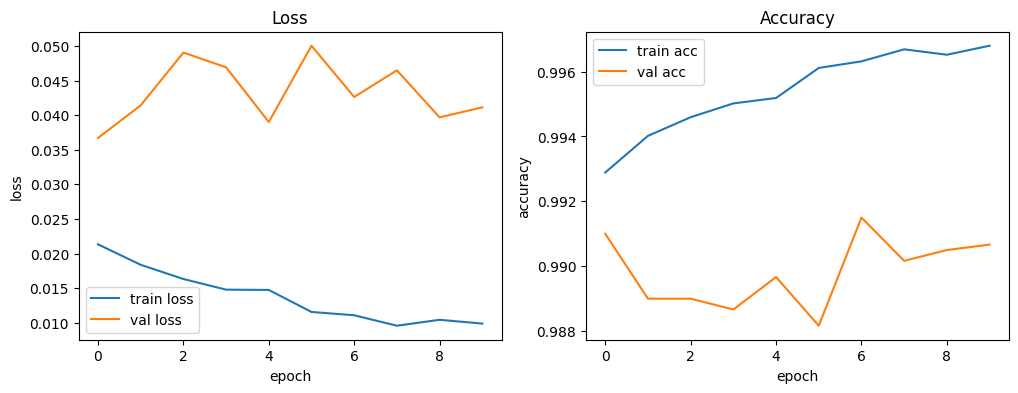

In [16]:
# Plot training history (loss and accuracy)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend(); plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('epoch'); plt.ylabel('accuracy'); plt.legend(); plt.title('Accuracy')
plt.show()

In [8]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test accuracy:", test_accuracy)


313/313 [==============================] - 0s 963us/step - loss: 0.0316 - accuracy: 0.9901
Test accuracy: 0.9901000261306763


## Step 9: Validate and visualise predictions

1/1 [==============================] - 0s 9ms/step


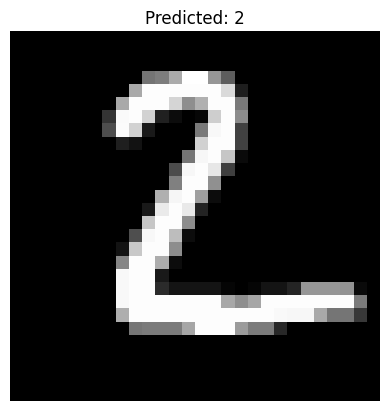

In [10]:
# Example inference and visualization for a single test example
index = 1
prediction = model.predict(x_test[index:index+1])
predicted_label = np.argmax(prediction)

plt.imshow(x_test[index].squeeze(), cmap='gray')
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()
